In [1]:
import scanpy as sc
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scBTF
import rich
import ipywidgets as widgets


from pathlib import Path
from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet, Factorization, BayesianCP
scBTF.__version__

'0.1.21'

In [2]:
torch.set_num_threads(8)

ROOT = (Path('__file__').resolve().parent)

DATA_FOLDER = os.path.join(ROOT, "data/")
RESULTS_FOLDER = os.path.join(ROOT, "results/")
FIGURES_FOLDER = os.path.join(ROOT, "figures/")

In [3]:
adata_path = "/home/dchafamo/final/data/combined_dataset_final_v2.h5ad"
hl_lr_proximity_score_path = "/home/dchafamo/final/data/HL_liana_05_single_final.csv"
rln_lr_proximity_score_path = "/home/dchafamo/final/data/RLN_liana_05_single.csv"

sample_label = "donor"
celltype_label = "cell_types_level_3"
communication_score = 'expression_gmean'
weight_proximity_score = 10
ligand_celltypes = ['B_cells', 'Plasma_cells',]
receptor_celltypes = ['CD4_T_cells', 'CD8_T_cells', 'Macrophages', 'mDC', 'Monocytes', 'pDC', 'NK_cells', 'FDC', 'T_other']

run_name = 'B_to_immune'
ranks = [6, 8, 10, 12, 14, 16]

In [4]:
adata = sc.read(adata_path)
print(adata.shape)

(308403, 29786)


In [5]:
def get_lr_proximity_score(lr_proximity_score_path, logfdr_threshold = 3):
    LR_spatial = pd.read_csv(lr_proximity_score_path)
    LR_spatial = LR_spatial.loc[LR_spatial['300p_-logfdr'] > 3]
    print(LR_spatial.shape)

    LR_spatial['lr_id'] = (
        LR_spatial['source'] + '_' + 
        LR_spatial['target'] + '_' +
        LR_spatial['ligand.complex'] + '_' + 
        LR_spatial['receptor.complex']
    ).values 
    return LR_spatial.set_index('lr_id').to_dict()['300p_effect']

In [6]:
hl_lr_proximity_score = get_lr_proximity_score(hl_lr_proximity_score_path)
rln_lr_proximity_score = get_lr_proximity_score(rln_lr_proximity_score_path)

(43958, 26)
(54255, 26)


In [7]:
# LR source 'https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv'  
cell_types = ['CD4_T_cells', 'B_cells', 'CD8_T_cells', 'Macrophages', 'Fibroblasts',
           'Plasma_cells', 'mDC', 'Tumor', 'Monocytes', 'pDC', 'NK_cells', 'LEC',
           'BEC', 'FDC', 'T_other']

sc_tensor = SingleCellTensor.from_anndata_ligand_receptor(
    adata, sample_label=sample_label, celltype_label=celltype_label, cell_types=cell_types,
    enrich_db_genes_only=False, filter_gene_count=None, scale_to=1e5, normalize=True,
    variance_scale=False, communication_score=communication_score
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.02s/it]


In [8]:
HL_sample_indices = np.where(sc_tensor.sample_features.loc[sc_tensor.sample_list, 'condition'] == 'HL')[0]

In [9]:
for h in range(len(sc_tensor.sample_list)):
    for i in range(len(sc_tensor.celltype_list)):
        for j in range(len(sc_tensor.region_list)):
            for k in range(len(sc_tensor.gene_list)):
                lr_proximity_score = hl_lr_proximity_score if h in HL_sample_indices else rln_lr_proximity_score
                lr_id = f'{sc_tensor.celltype_list[i]}_{sc_tensor.region_list[j]}_{sc_tensor.gene_list[k]}'
                if lr_id in lr_proximity_score:
                    sc_tensor.tensor[h,i,j,k] += (weight_proximity_score * lr_proximity_score[lr_id] * sc_tensor.tensor[h,i,j,k])

lg_index = [c in ligand_celltypes for c in sc_tensor.celltype_list]
rc_index = [c in receptor_celltypes for c in sc_tensor.celltype_list]

sc_tensor.tensor = sc_tensor.tensor[:,lg_index,:,:][:,:,rc_index,:].squeeze()

if len(ligand_celltypes) > 1:
    sc_tensor.region_list = np.array(sc_tensor.celltype_list)[rc_index]
    sc_tensor.celltype_list = np.array(sc_tensor.celltype_list)[lg_index]
else:
    sc_tensor.celltype_list = np.array(sc_tensor.celltype_list)[rc_index]
    
print(sc_tensor.tensor.shape)
print(f"Percent zeroes = {np.round(sum(sc_tensor.tensor.flatten()==0) / len(sc_tensor.tensor.flatten())*100,2)}")

(15, 2, 9, 4317)
Percent zeroes = 52.48


Decomposing tensor of shape (15, 2, 9, 4317) into rank 6 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:55<00:00,  7.11s/it]


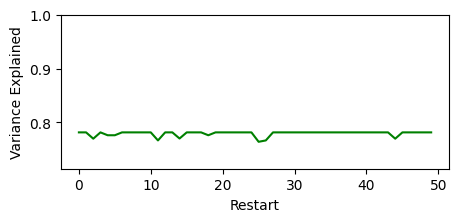

Decomposing tensor of shape (15, 2, 9, 4317) into rank 8 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:22<00:00, 14.85s/it]


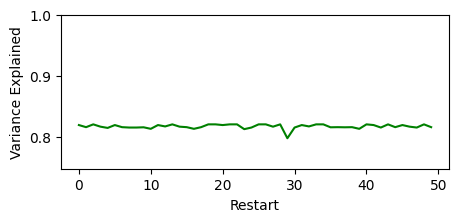

Decomposing tensor of shape (15, 2, 9, 4317) into rank 10 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:34<00:00, 18.68s/it]


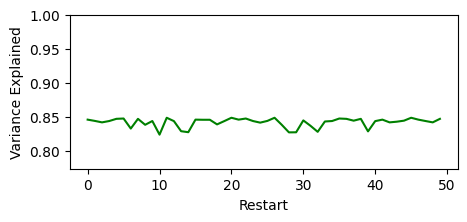

Decomposing tensor of shape (15, 2, 9, 4317) into rank 12 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [27:58<00:00, 33.56s/it]


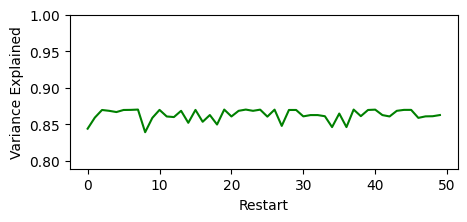

Decomposing tensor of shape (15, 2, 9, 4317) into rank 14 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [40:32<00:00, 48.64s/it]


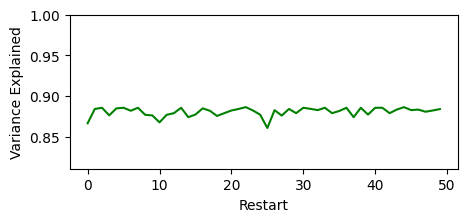

Decomposing tensor of shape (15, 2, 9, 4317) into rank 16 matrices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [53:11<00:00, 63.84s/it]


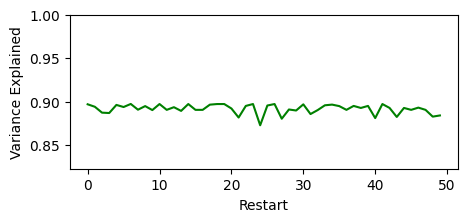

In [21]:
factorization_set = SingleCellBTF.factorize_hals(
    sc_tensor = sc_tensor, 
    rank = ranks, 
    num_steps = 2500,
    n_restarts = 50,
    plot_var_explained = True
)

In [11]:
sf = factorization_set.sc_tensor.sample_features
sf.loc['H09_370','ebv_status'] = 'positive'
sf['sample_type'] = sf['condition'].astype(str) + sf['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
sf['sample_type'] = sf['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})
rich.print(sf['sample_type'].value_counts())
factorization_set

HL EBV+    5
HL EBV-    5
RLN        5
Name: sample_type, dtype: int64

Single cell factorization object with the following params:
        Tensor size 15 x 2 x 9 x 4317
        Ranks: [6, 8, 10, 12, 14, 16]

In [23]:
factorization_set.save(f"results/{run_name}.pkl")

Saved SingleCellTensor object to path results/B_to_immune.pkl


In [24]:
factorization_set = FactorizationSet.load(f"results/{run_name}.pkl")
factorization_set

Single cell factorization object with the following params:
        Tensor size 15 x 2 x 9 x 4317
        Ranks: [6, 8, 10, 12, 14, 16]

### Rank selection

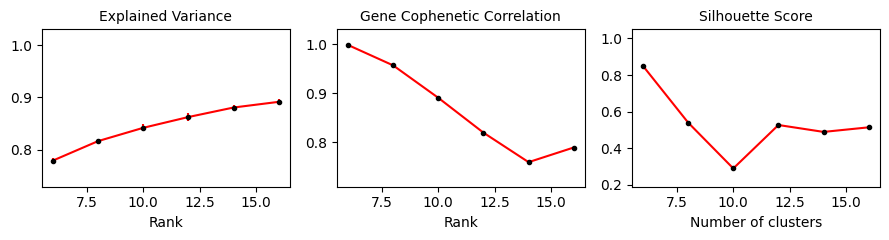

In [25]:
fig = factorization_set.rank_metrics_plot(entropy=0, eps=0, force=True)

In [26]:
fig.savefig(f'results/{run_name}_rank_metrics.png', dpi=300, bbox_inches="tight")

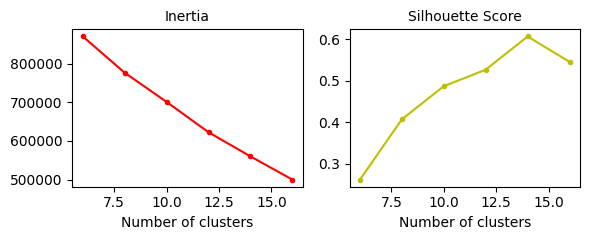

In [27]:
factorization_set.plot_gene_factor_cluster_metrics_per_rank(rank=12)
print()

### Reconstruct factorization from median

In [28]:
force = True
save_path = f"results/consensus_{run_name}.pkl"
if force or (not os.path.exists(save_path)):
    factorization_set.sc_tensor.tensor = factorization_set.sc_tensor.tensor.round()
    consensus_factorization = FactorizationSet()
    for selected_rank in list(factorization_set.get_ranks()):
        reconstructed = SingleCellBTF.get_consensus_factorization(
            factorization_set = factorization_set, rank = selected_rank, model = 'gamma_poisson_fixed',
            init_alpha = 1e2, init_beta = 1.0, fixed_mode = 3, fixed_mode_variance = 10., n_neighbors= 50,
            contamination = 0.01, num_steps = 5000, initial_lr = 1e-1, lr_decay_gamma = 1e-1, 
            filter_outliers = False
        )
        consensus_factorization.factorizations[selected_rank] = reconstructed.factorizations[selected_rank]
    consensus_factorization.sc_tensor = factorization_set.sc_tensor
    consensus_factorization.save(save_path)
else:
    consensus_factorization = FactorizationSet.load(save_path)
consensus_factorization

Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 6 matrices


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:47<00:00, 647.73s/it]


417 / 25902 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.4414522051811218
Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 8 matrices


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:20<00:00, 80.45s/it]


460 / 34536 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.632210373878479
Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 10 matrices


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.36s/it]


407 / 43170 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.7023110389709473
Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 12 matrices


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.46s/it]


567 / 51804 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.7536200284957886
Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 14 matrices


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.10s/it]


666 / 60438 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.7601109147071838
Decomposing tensor of shape torch.Size([15, 2, 9, 4317]) into rank 16 matrices


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.29s/it]

818 / 69072 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.7288205623626709
Saved SingleCellTensor object to path results/consensus_B_to_immune.pkl


Single cell factorization object with the following params:
        Tensor size 15 x 2 x 9 x 4317
        Ranks: [6, 8, 10, 12, 14, 16]

### Visualize factors

In [29]:
children = []
for rank in sorted(list(consensus_factorization.get_ranks())):
    out = widgets.Output()
    with out:
        fig = consensus_factorization.plot_components(
            rank=rank, restart_index=0, threshold = 0.4, entropy = 1, eps = 0, sort_by = 'other',
            title = False, plot_erichment_terms=False, normalize_gene_factors=True, bbox_to_anchor=(1.25,0.5)
        )
        plt.show(fig)
    children.append(out)
tab = widgets.Tab(children = children)
for index, rank in enumerate(sorted(list(consensus_factorization.get_ranks()))):
    tab.set_title(index, f'Rank {rank}')
display(tab)

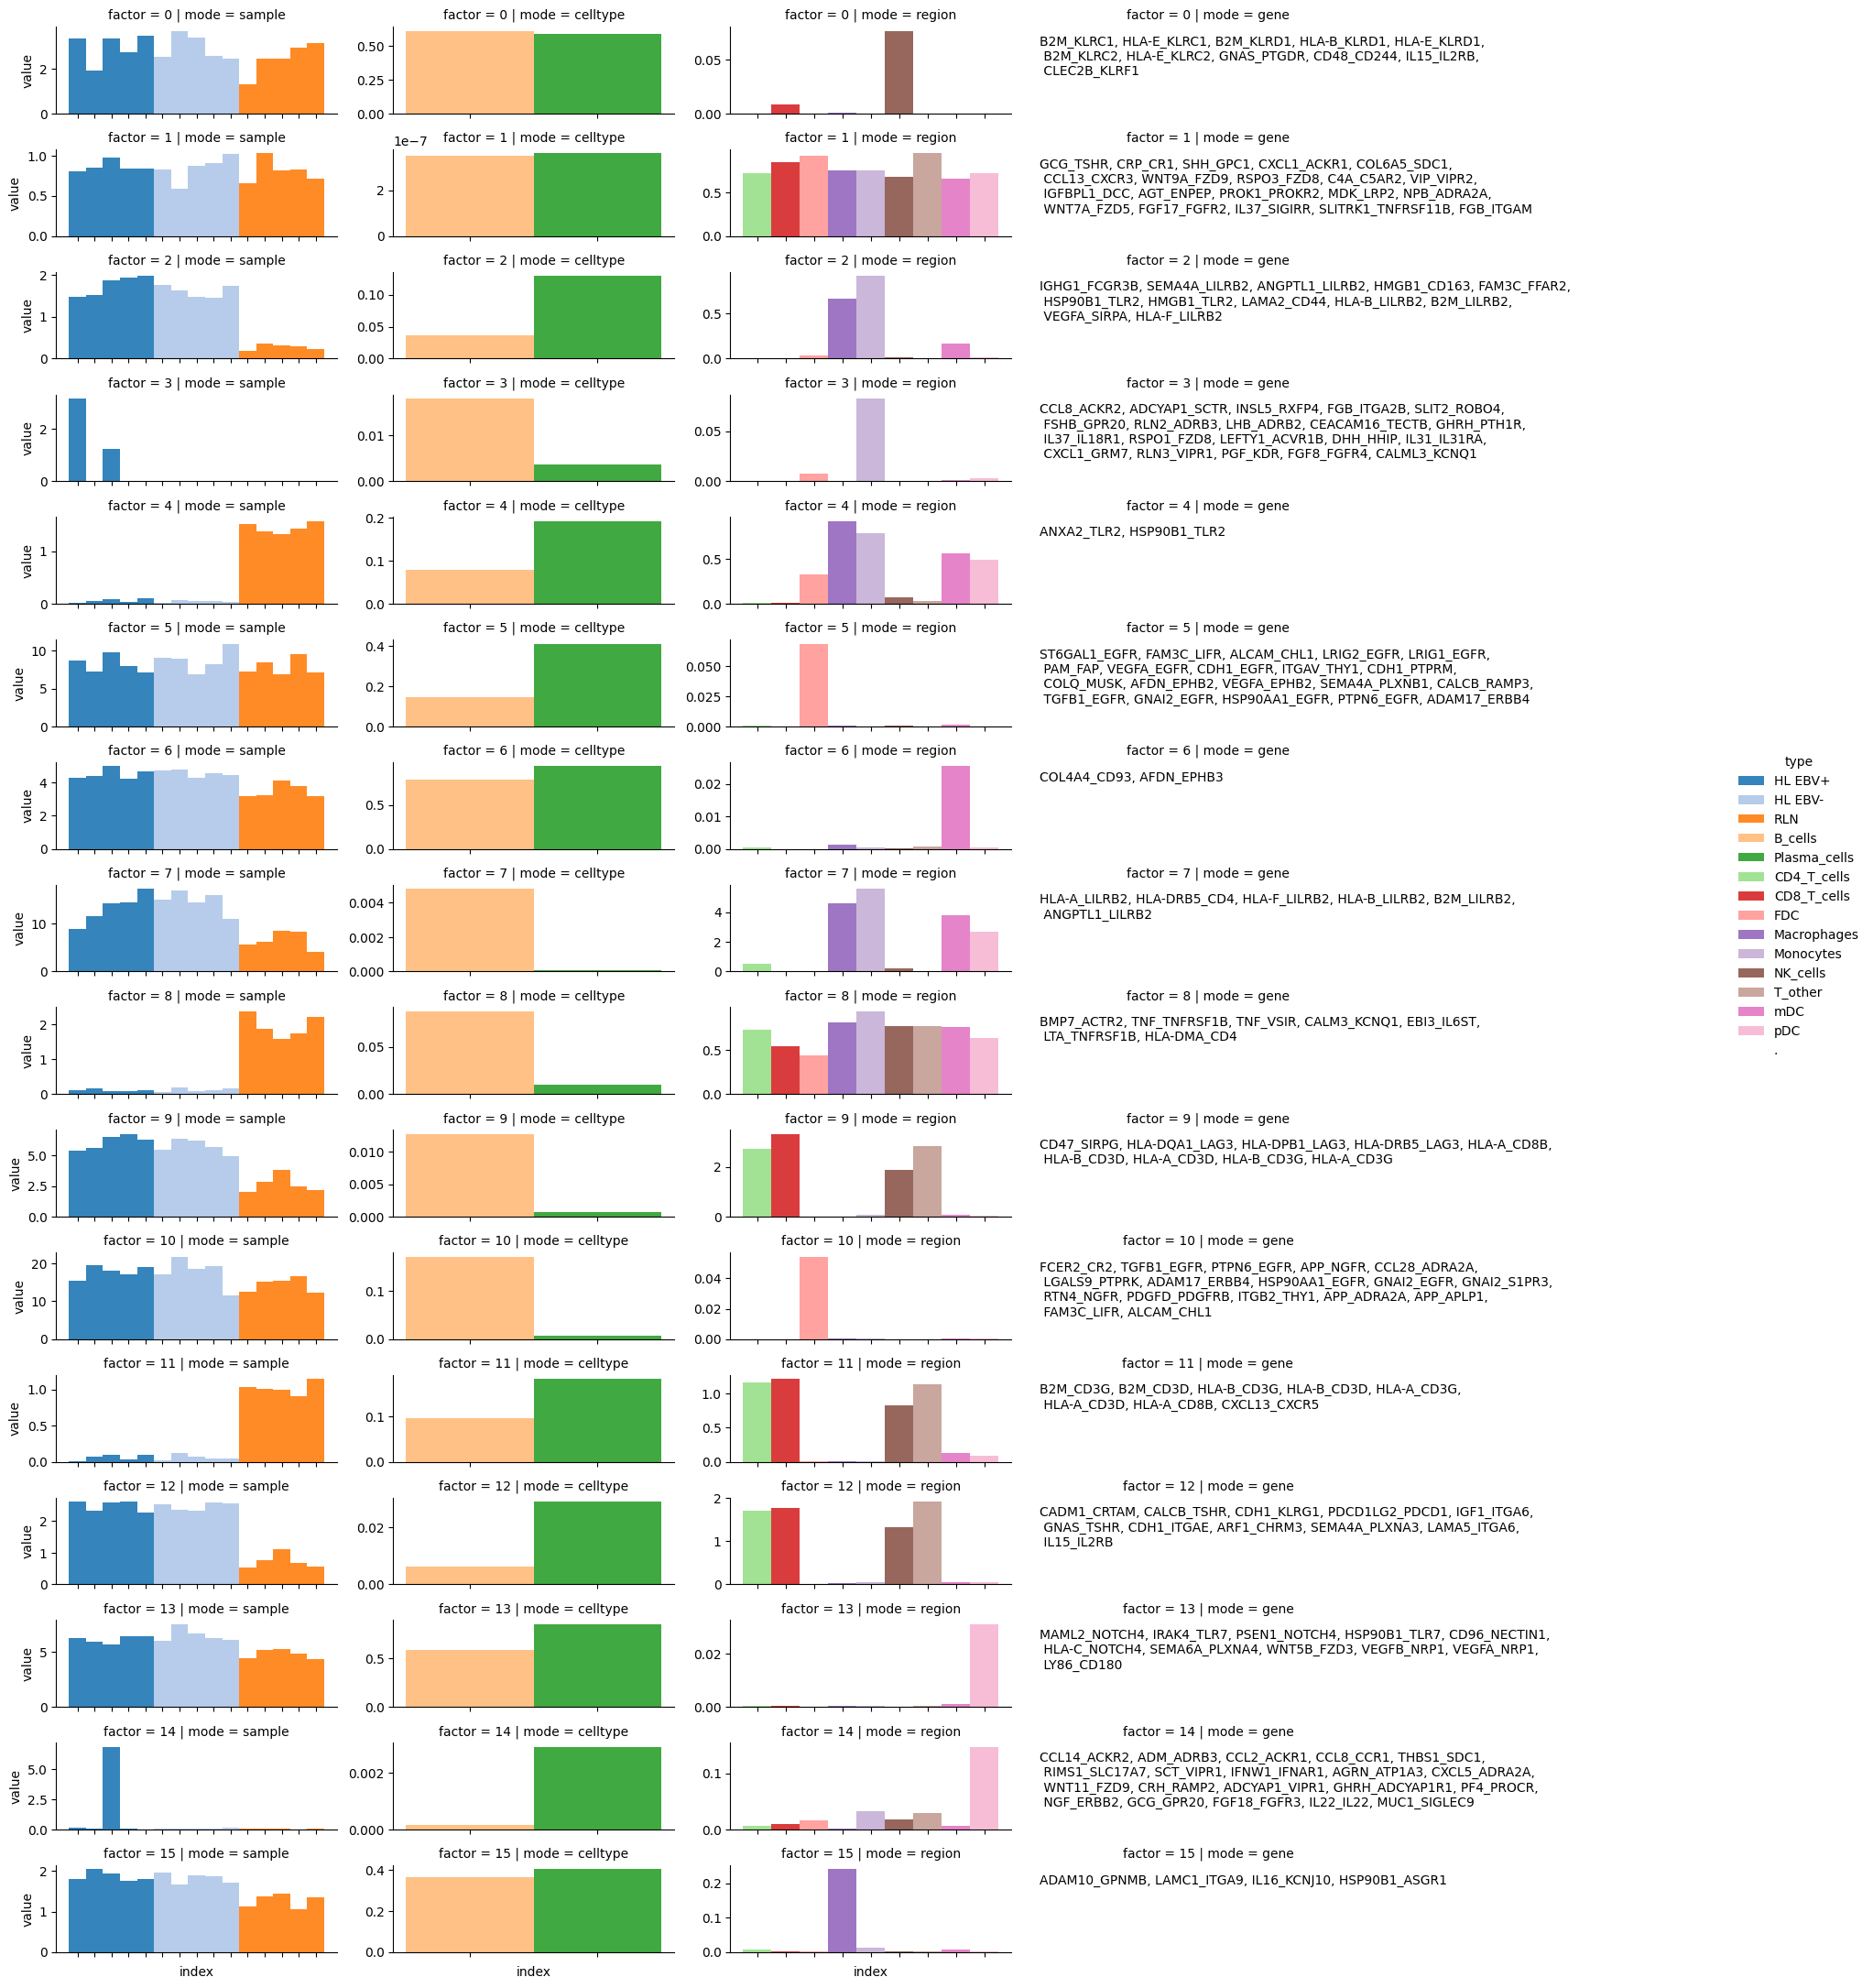

Saved gene program for rank 16 at results/B_to_immune/

In [30]:
consensus_factorization.save_rank_results(rank=16, dir_path=f'results/{run_name}/',
                                          plot_erichment_terms=False, bbox_to_anchor=(1.25,0.5) )